In [37]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import seaborn

# Accuracies

In [38]:
accuracies = list(pathlib.Path(".").glob("*accuracy.npy"))
acc_names = [' '.join(x.name.split("_")[:-1]).title() for x in accuracies]
accuracies = [np.load(x) for x in accuracies]
acc_names

['Spyx',
 'Sinabs',
 'Lava',
 'Snntorch',
 'S2',
 'S2 Brian2',
 'Nengo',
 'Speck',
 'Norse']

In [39]:
acc_df = pd.DataFrame(accuracies, index=acc_names, columns=["Accuracy"]).T.sort_index(axis=1)
acc_df

,Lava,Nengo,Norse,S2,S2 Brian2,Sinabs,Snntorch,Speck,Spyx
Accuracy,0.981507,0.9811,0.9811,0.982,0.982,0.9847,0.979035,0.954,0.971222


In [40]:
print(acc_df.to_latex(float_format="{:.3f}".format, bold_rows=True))

\begin{tabular}{lrrrrrrrrr}
\toprule
 & Lava & Nengo & Norse & S2 & S2 Brian2 & Sinabs & Snntorch & Speck & Spyx \\
\midrule
\textbf{Accuracy} & 0.982 & 0.981 & 0.981 & 0.982 & 0.982 & 0.985 & 0.979 & 0.954 & 0.971 \\
\bottomrule
\end{tabular}



# Confusion matrix

In [41]:
sorted(["a 1", "a"])

['a', 'a 1']

In [42]:
def format_name(x):
    return (" ".join(x.split("_")[:-1]).replace(" corrected", "").title().replace("Snntorch", "snnTorch").replace("S2", "SpiNNaker2").replace("SpiNNaker2 Brian2", "SpiNNaker2$^\dagger$")
           )
activities = [str(x.name) for x in pathlib.Path(".").glob("*activity.npy")]
activities.remove("s2_brian2_uncorrected_activity.npy")
activities.remove("s2_uncorrected_activity.npy")
names = [format_name(x) for x in activities]
sort_idx = np.argsort([x.lower() for x in names])
names = [names[x] for x in sort_idx]
activities = [activities[x] for x in sort_idx]
activities = [np.load(str(p)) for p in activities]
names

['Lava',
 'Nengo',
 'Norse',
 'Sinabs',
 'snnTorch',
 'Speck',
 'SpiNNaker2',
 'SpiNNaker2$^\\dagger$',
 'Spyx']

In [43]:
activities[-2][:-1].shape

(299, 10, 16, 16, 16)

In [44]:
metric = torch.nn.CosineSimilarity(0)
divs = pd.DataFrame(index=names)
for i in range(len(activities)):
  act_row = []
  for i_col in range(len(activities)):
    a1 = torch.tensor(activities[i]).float().mean(0).flatten(0)
    a2 = torch.tensor(activities[i_col]).float().mean(0).flatten(0) 
    dist = metric(a1, a2)
    act_row.append(dist.item())
  divs[names[i]] = act_row
divs

,Lava,Nengo,Norse,Sinabs,snnTorch,Speck,SpiNNaker2,SpiNNaker2$^\dagger$,Spyx
Lava,1.000000,1.000000,1.000000,0.668887,0.785451,0.830536,0.997176,0.997176,0.994234
Nengo,1.000000,1.000000,1.000000,0.668887,0.785451,0.830536,0.997176,0.997176,0.994234
Norse,1.000000,1.000000,1.000000,0.668887,0.785451,0.830536,0.997176,0.997176,0.994234
Sinabs,0.668887,0.668887,0.668887,1.000004,0.711818,0.761078,0.667697,0.667697,0.665662
snnTorch,0.785451,0.785451,0.785451,0.711818,1.000002,0.971020,0.785845,0.785845,0.803696
Speck,0.830536,0.830536,0.830536,0.761078,0.971020,1.000000,0.829756,0.829756,0.838839
SpiNNaker2,0.997176,0.997176,0.997176,0.667697,0.785845,0.829756,0.999999,0.999999,0.994006
SpiNNaker2$^\dagger$,0.997176,0.997176,0.997176,0.667697,0.785845,0.829756,0.999999,0.999999,0.994006
Spyx,0.994234,0.994234,0.994234,0.665662,0.803696,0.838839,0.994006,0.994006,1.000001


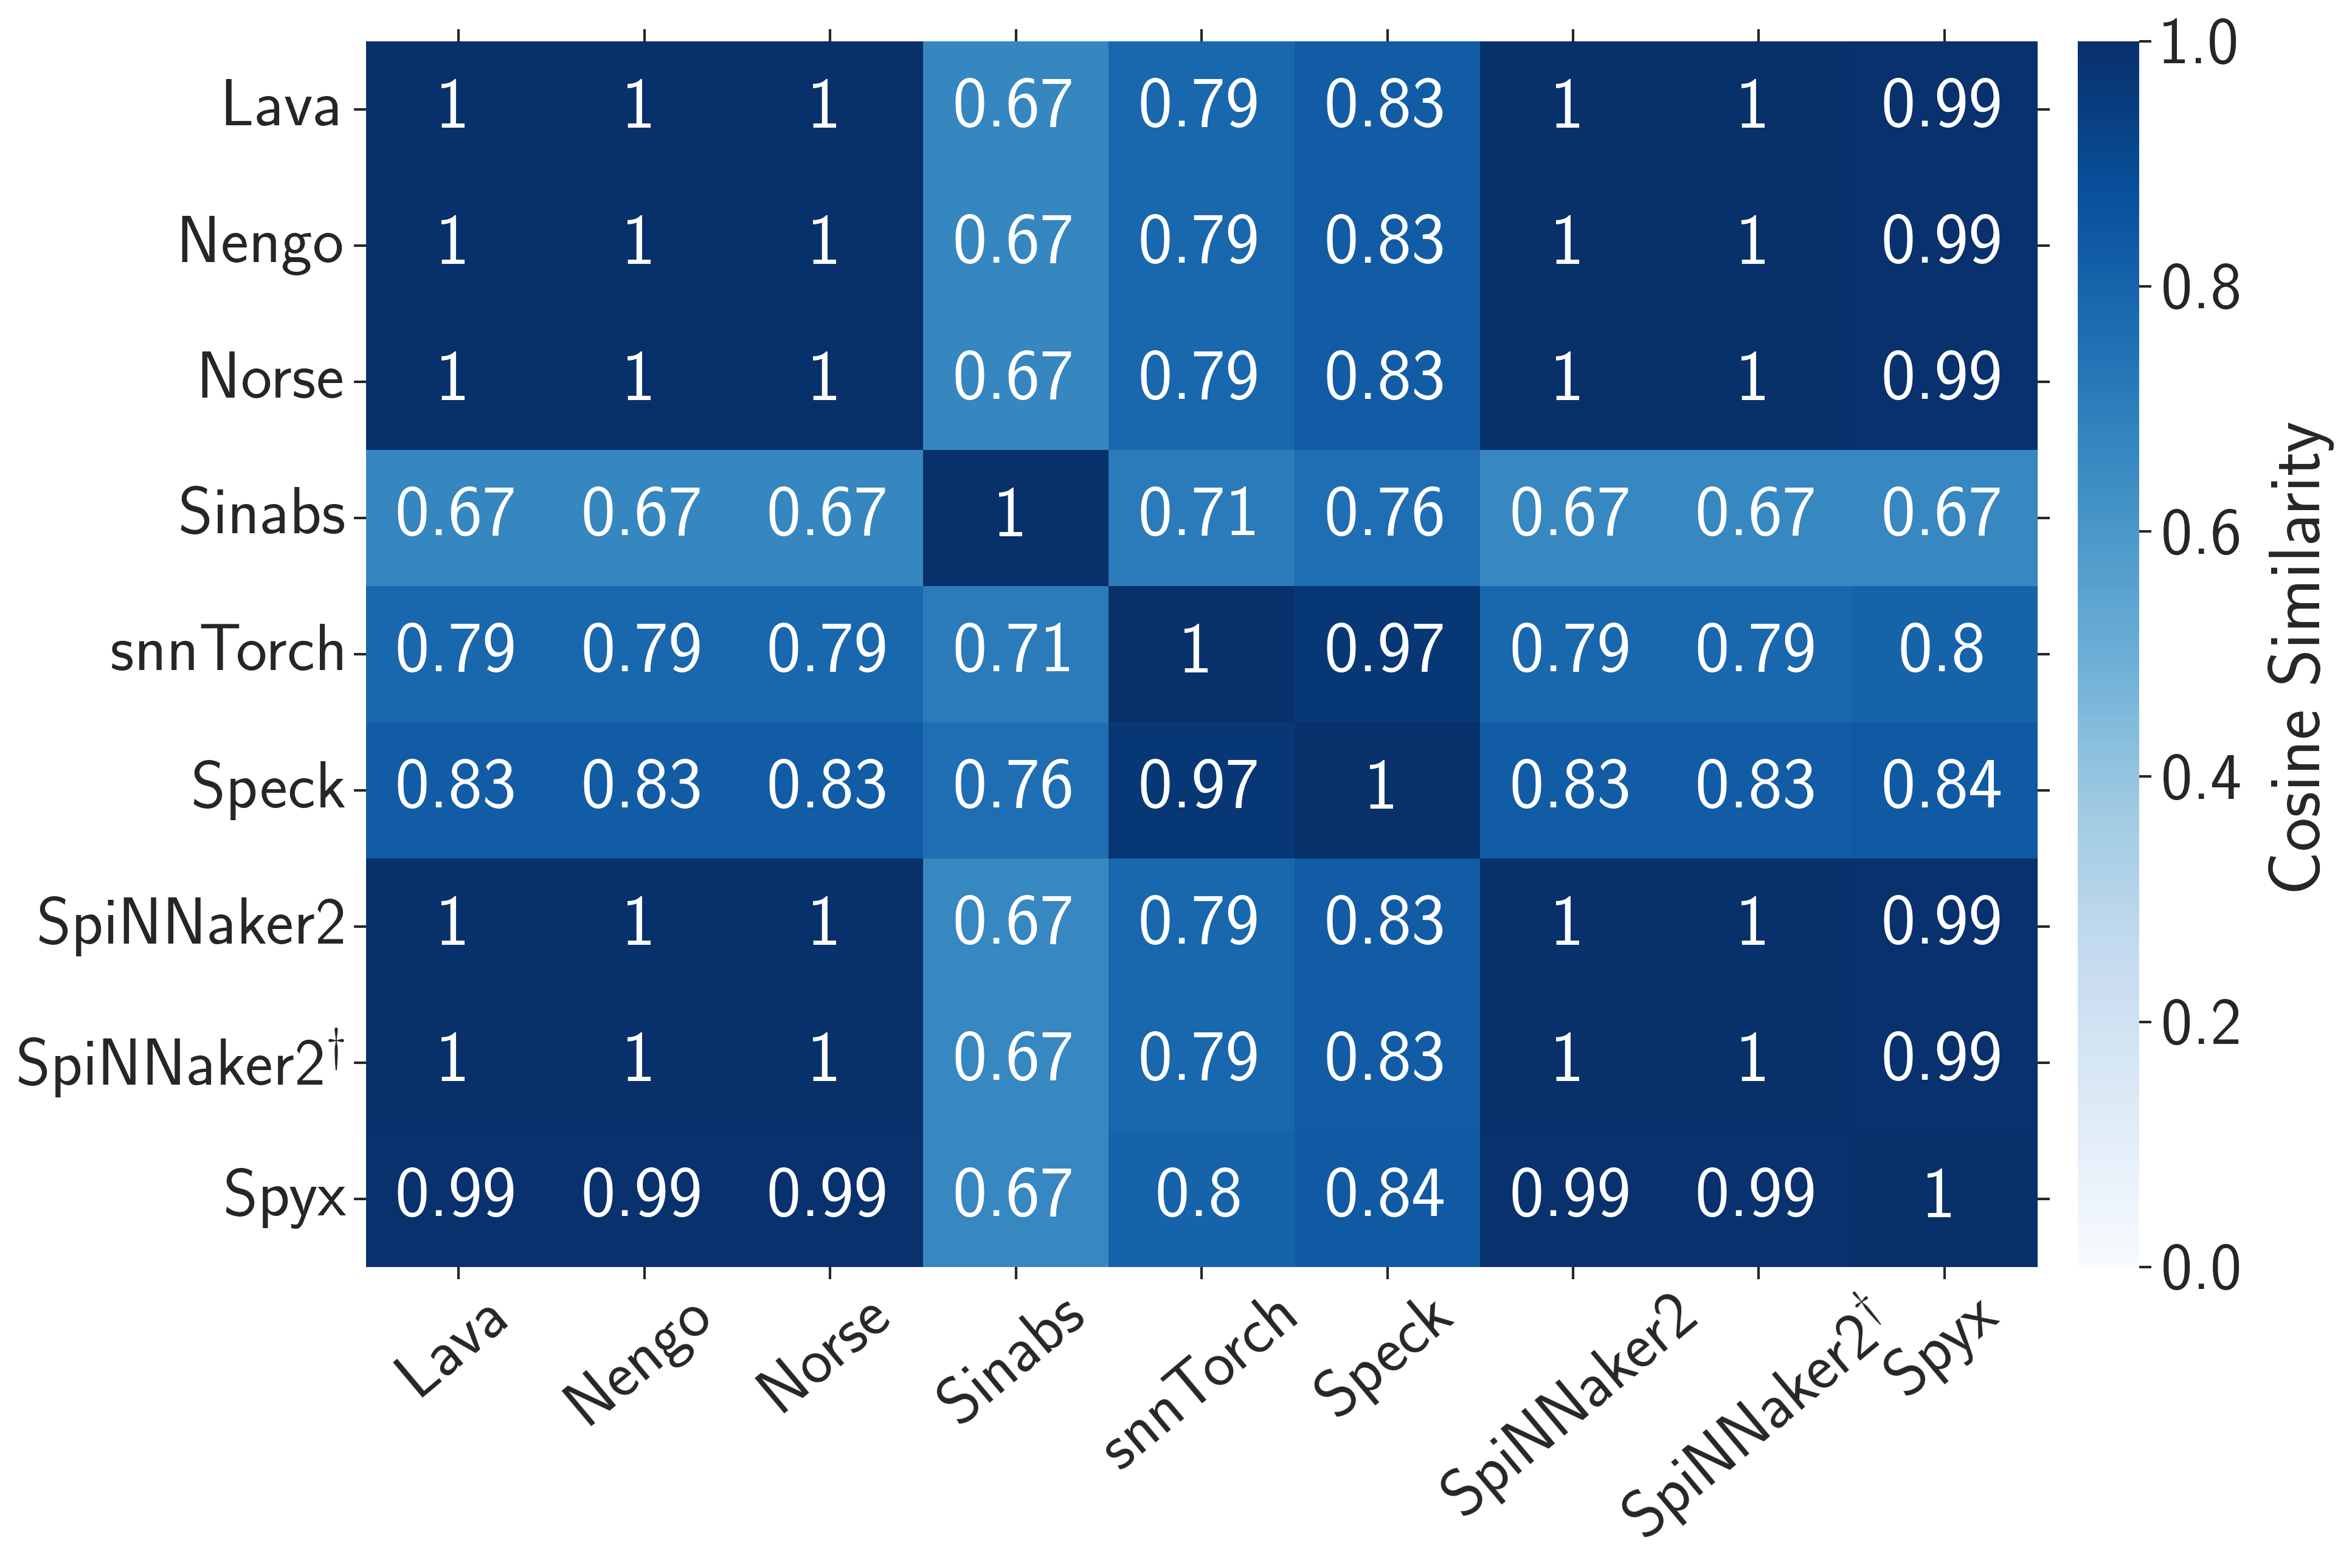

In [45]:
plt.style.use("../plots.mplstyle")
seaborn.set_context("paper", font_scale=3)
seaborn.set_style("whitegrid")

f, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=300)
seaborn.heatmap(divs.abs(), ax=ax, cmap="Blues", cbar_kws={"pad": 0.02}, annot=True, vmin=0)
ax.collections[0].colorbar.set_label("Cosine Similarity", labelpad=10)
# ax.collections[0].colorbar.ax.yaxis.set_ticks_position("left")
ax.collections[0].colorbar.ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
ax.collections[0].colorbar.ax.tick_params(pad=5)
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_tick_params(rotation=40)
f.savefig("../figures/conv_similarity.pdf", bbox_inches="tight")

# Plot digit input

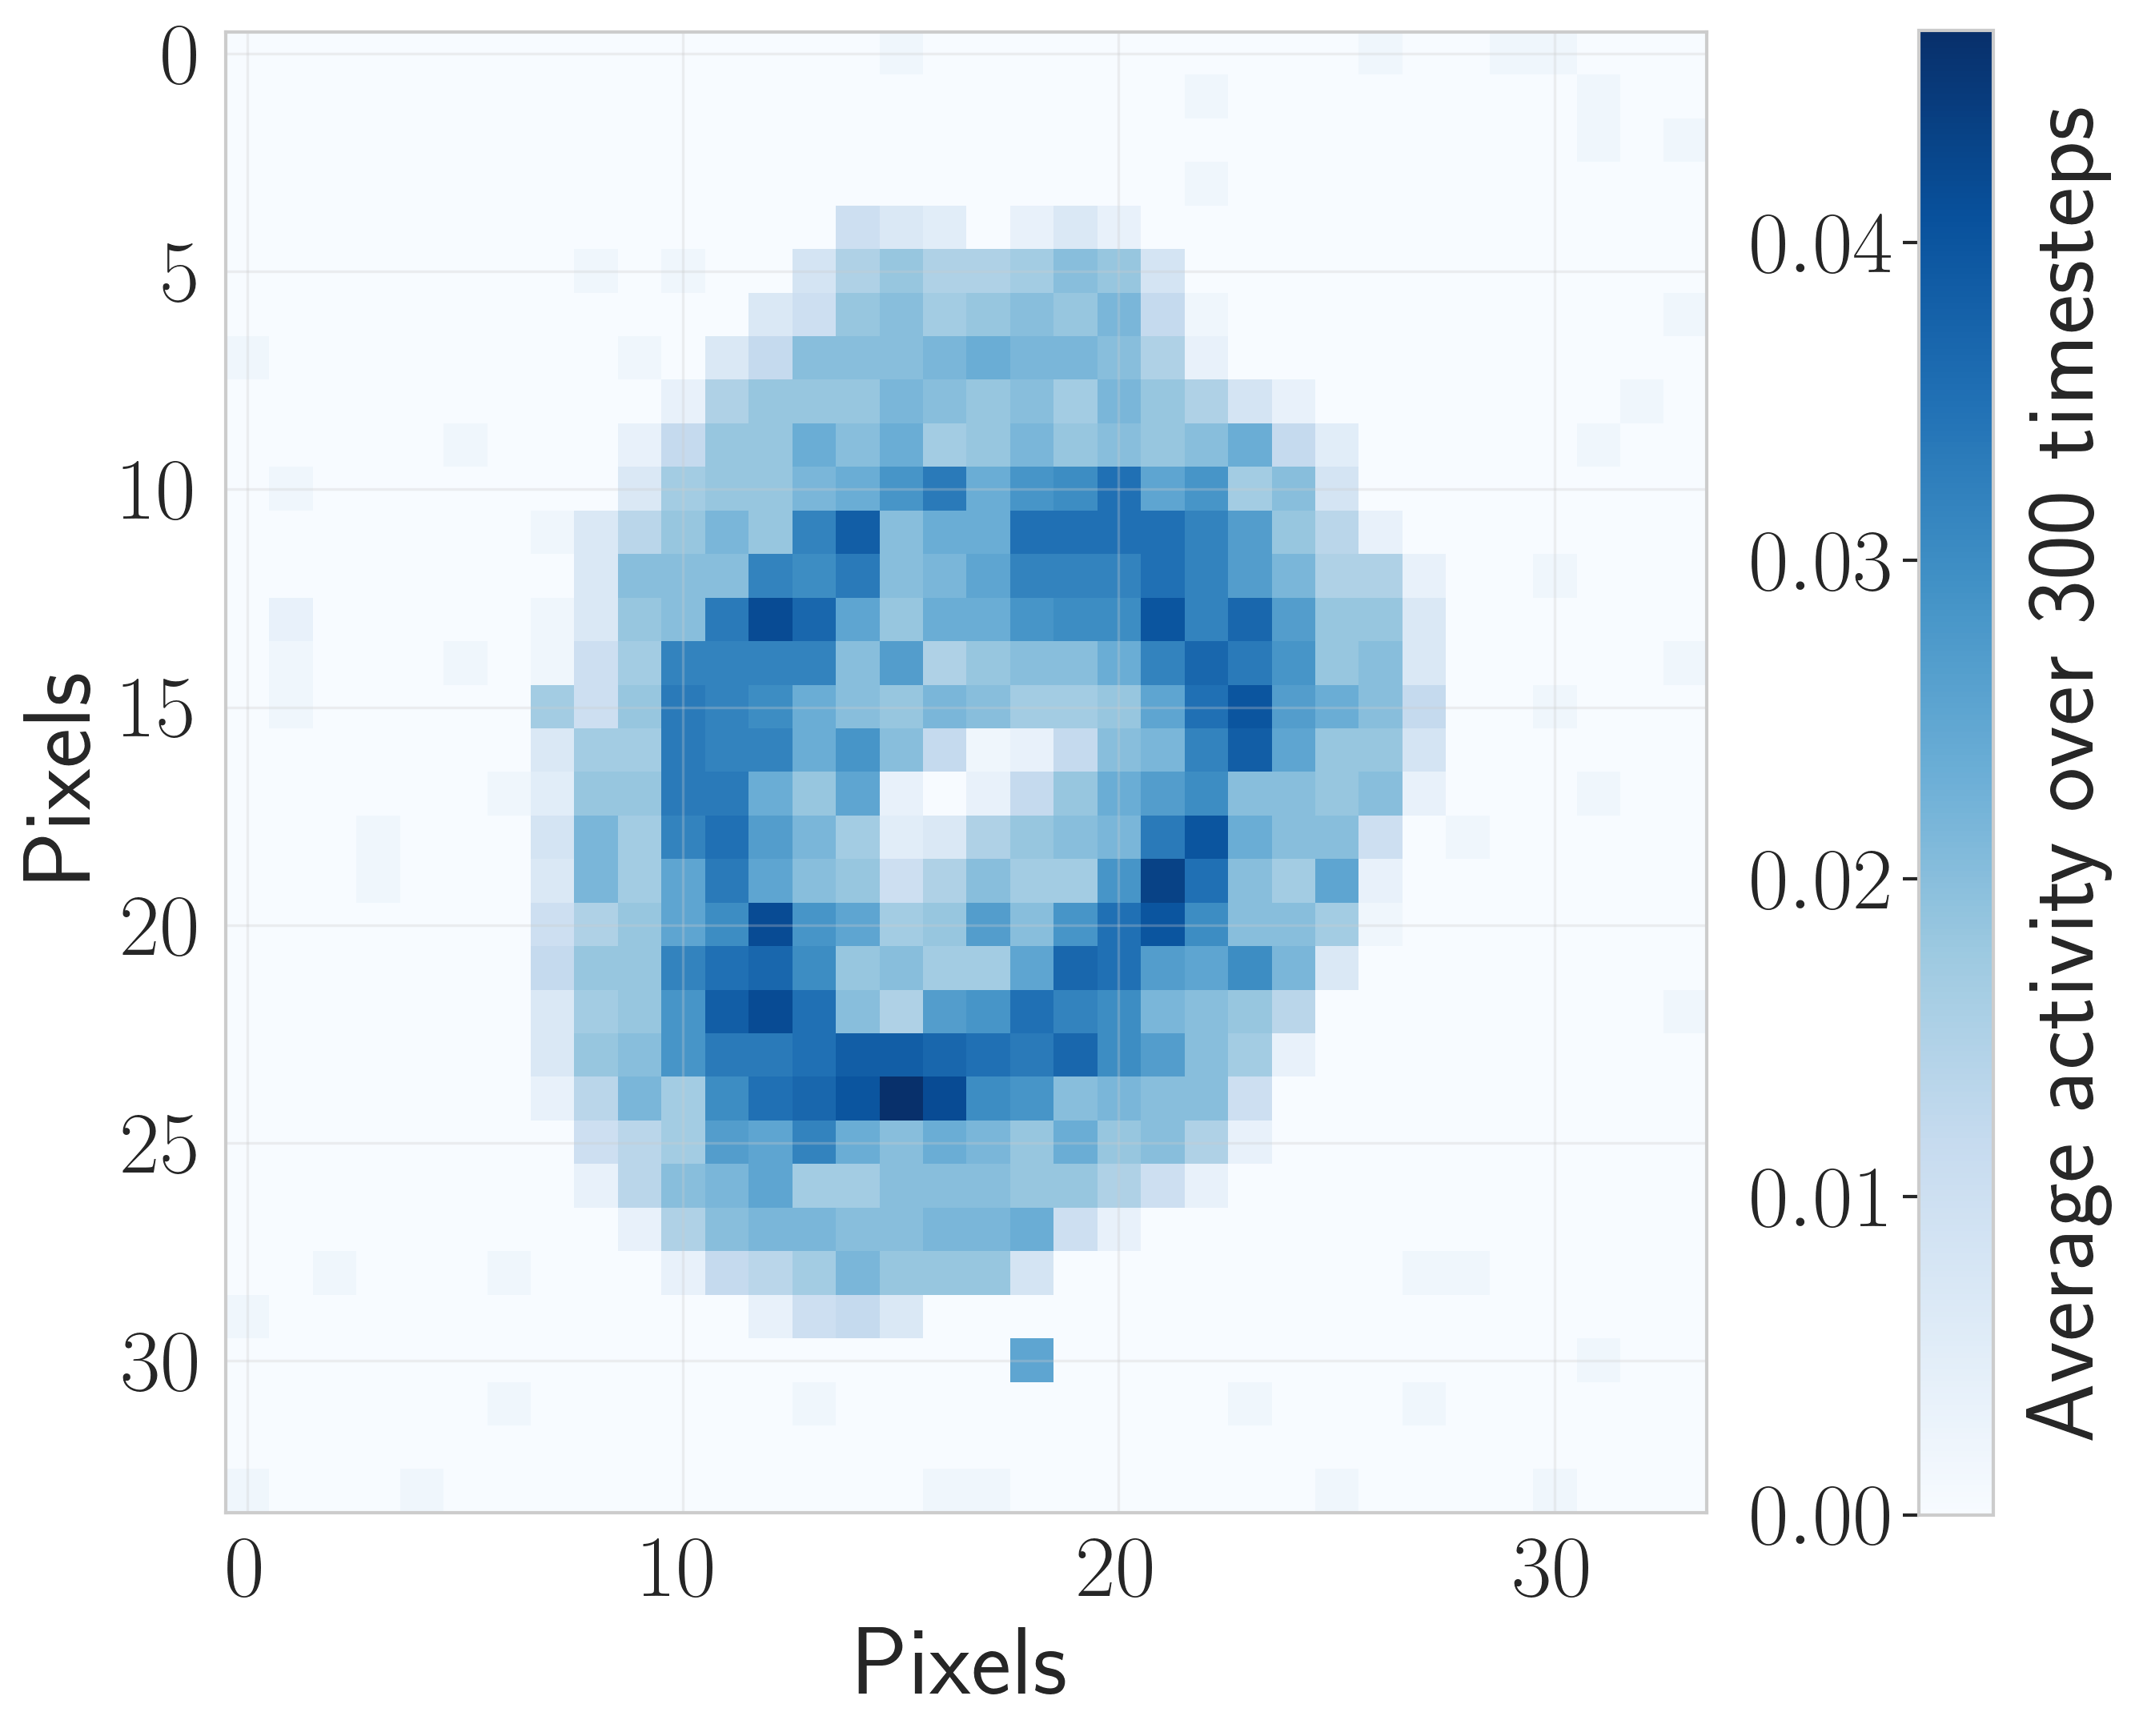

In [74]:
f, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
cax = ax.imshow(np.load("val_numbers.npy").mean(0)[0].mean(0), cmap="Blues")
cbar = f.colorbar(cax, fraction=0.042, pad=0.12)
cbar.ax.yaxis.set_ticks_position('left')
cbar.set_label("Average activity over 300 timesteps", labelpad=10)
ax.set_xlabel("Pixels")
ax.set_ylabel("Pixels")
f.savefig("../figures/nmnist_zero.pdf", bbox_inches="tight")